In [4]:
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from lbl2vec import Lbl2Vec
from gensim.downloader import load
import numpy as np

# Plan Overview:
0. Keyword Definition
1. Data Preparation
2. Model Training

### 0. Keyword Definition

#### Categories:

    1.  Bike Lane Obstruction: bike, cycle, path,  
    2.  Bus Lane Obstruction: bus, stop, 
    3.  Non-resident Parking: resident, state
    4.  Blocked Fire Hydrant: fire, hydrant
    5.  Blocked Sidewalk: sidewalk, side, walk
    6.  Blocked Driveway: driveway, drive, way, private
    7.  Blocked Crosswalk: crosswalk, cross, walk
    8.  Blocked Handicap spot: handicap, placard,
    9.  Double Parking: double, triple
    10. No stopping zone: stopping, zone
    11. visitor spot: visitor, hour

In [5]:
category_keywords_dict = {
    'bike lane' :           ['bike', 'cycle', 'cycling', 'path', 'sharrow'],
    'bus lane' :            ['bus'],
    'resident parking' :    ['resident', 'state', 'plate', 'plates'],
    'fire hydrant' :        ['fire', 'hydrant'],
    'sidewalk' :            ['sidewalk', 'side'],
    'driveway' :            ['driveway', 'drive', 'way', 'private'],
    'crosswalk' :           ['crosswalk', 'cross'],
    'handicap' :            ['handicap', 'placard'],
    'double parking' :      ['double', 'triple'],
    'no stopping' :         ['stopping', 'loading'],
    'visitor parking' :     ['visitor', 'hour']
} 

category_keywords = pd.DataFrame(data=category_keywords_dict.items(), columns=['category', 'keywords'])
category_keywords

,category,keywords
0,bike lane,"[bike, cycle, cycling, path, sharrow]"
1,bus lane,[bus]
2,resident parking,"[resident, state, plate, plates]"
3,fire hydrant,"[fire, hydrant]"
4,sidewalk,"[sidewalk, side]"
5,driveway,"[driveway, drive, way, private]"
6,crosswalk,"[crosswalk, cross]"
7,handicap,"[handicap, placard]"
8,double parking,"[double, triple]"
9,no stopping,"[stopping, loading]"


### 1. Data Preparation (Add Lemmatization)

In [6]:
# Load pickled service descriptions
with open('pre-processing/API-responses/service_req_desc_03-02-24_01_09_24.pkl', 'rb') as file:
    service_id_to_descriptions:dict = pickle.load(file)

# Remove special characters and downcase, then tokenize
def tokenize(doc):
    return simple_preprocess(doc, deacc=True, min_len=2, max_len=15)

service_drescriptions_df = pd.DataFrame(data=service_id_to_descriptions.items(), columns=['ID', 'Description'])
service_drescriptions_df.head()

,ID,Description
0,101005335950,Illegal parking in the commercial loading Zone...
1,101005335949,Red Honda w New York plates illegally parked o...
2,101005335934,Car completely blocking turn in fire lane
3,101005335925,Double parking alone mass ave. No enforcement....
4,101005335924,truck on sidewalk


#### Test, Training, Validate Split

In [7]:
# Train=.70, Validate=.15, Test=.15
# Split all data between train, (test AND validate)
desc_train, desc_testval = train_test_split(service_drescriptions_df, test_size=.3)

# Split (test AND validate) between test, validate
# .3 * .5 = 0.15
desc_val, desc_test = train_test_split(desc_testval, test_size=0.5)

In [8]:
desc_train['data_type'] = 'train'
desc_test['data_type'] = 'test'
desc_val['data_type'] = 'validate'

all_descriptions = pd.concat([desc_train, desc_test, desc_val]).reset_index(drop=True)
all_descriptions.head()

,ID,Description,data_type
0,101005283339,Constituent reports there is a vehicle that i ...,train
1,101005247599,Car parked on street side with no parking sig...,train
2,101005279192,Improper assessment of illegal parking. Car mu...,train
3,101005327243,Cars parked in cab stand,train
4,101005284028,Illegal parking. The same car parks here at ni...,train


#### Service ID to Tag function

In [9]:
service_id_list = []
def service_id_to_tag(service_id:int) -> int:
    if service_id in service_id_list:
        return service_id_list.index(service_id)
    service_id_list.append(service_id)
    return len(service_id_list)

#### Tagging Descriptions

In [10]:
all_descriptions['tagged_desc'] = all_descriptions.apply(lambda row: TaggedDocument(tokenize(row['Description']), [service_id_to_tag(int(row['ID']))]), axis=1)
all_descriptions.head()

,ID,Description,data_type,tagged_desc
0,101005283339,Constituent reports there is a vehicle that i ...,train,"([constituent, reports, there, is, vehicle, th..."
1,101005247599,Car parked on street side with no parking sig...,train,"([car, parked, on, street, side, with, no, par..."
2,101005279192,Improper assessment of illegal parking. Car mu...,train,"([improper, assessment, of, illegal, parking, ..."
3,101005327243,Cars parked in cab stand,train,"([cars, parked, in, cab, stand], [4])"
4,101005284028,Illegal parking. The same car parks here at ni...,train,"([illegal, parking, the, same, car, parks, her..."


### 2. Model Training

In [11]:
model = Lbl2Vec(
    keywords_list=list(category_keywords['keywords']),
    tagged_documents=all_descriptions['tagged_desc'][all_descriptions['data_type'] == 'train'],
    vector_size=300, 
    min_count=1, 
    similarity_threshold=0.3
    )

model.fit()

2024-04-02 13:02:39,776 - Lbl2Vec - INFO - Train document and word embeddings
2024-04-02 13:02:52,963 - Lbl2Vec - INFO - Train label embeddings
2024-04-02 13:02:52,966 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: cycling sharrow


#### Predict Description Labels

In [12]:
simScores = model.predict_model_docs()

2024-04-02 13:02:54,091 - Lbl2Vec - INFO - Get document embeddings from model
2024-04-02 13:02:54,148 - Lbl2Vec - INFO - Calculate document<->label similarities


####  Manually Catagorize Data

In [13]:
def getDesAndIDOfKeyWord(dataframe, column, keyword, n_entries):
    """
    Filters the dataframe to only include rows where the specified column contains the keyword.

    Parameters:
    - dataframe: The pandas DataFrame to filter.
    - column: The name of the column in the DataFrame to search for the keyword.
    - keyword: The keyword to search for within the specified column.
    - n_entries: Number of entries to display.

    Prints the ID and Description of entries where the specified column contains the keyword
    """
    # Filter the DataFrame
    filtered_df = dataframe[dataframe[column].astype(str).str.contains(keyword, case=False, na=False)]
    
    # Get the first n_entries
    n_entDF = filtered_df.head(n_entries)

    # Print the desired output
    for index, row in n_entDF.iterrows():
        print(f"ID: {row['ID']}, {column}: {row[column]}")
    return n_entDF

In [14]:
gt_bus_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " bus ", 15).ID.array.astype(np.int64)
# IDs of 10 Bus Lane Incidents:

ID: 101005277584, Description: Cars allowed to clog bus lane and block in legally parked cars/spots
ID: 101005231550, Description: -- auto translated (en) -- Tow cars blocking bus top. Mbta passengers can’t board bus  -- original (en) -- Tow cars blocking bus top. Mbta passengers can’t board bus
ID: 101005288175, Description: Charlestown Liquors delivery in bus stop. Please enforce.
ID: 101005325686, Description: Truck blocking MBTA bus stop
ID: 101005300371, Description: Car in bus stop lane
ID: 101005284752, Description: Parked in bus stop. We need enforcement.
ID: 101005238694, Description: Vehicle parked in the bus stop and fire hydrant
ID: 101005301806, Description: Car parked in bus lane....ongoing.
ID: 101005186250, Description: -- auto translated (en) -- We’ve been reporting this area and nobody pays attention to any school areas until a person is hit Cedar street turns into a dangerous crawl between 8:30-9:15 am and 2:40-3:15 pm you all only come by and tag residents which is 

In [15]:
gt_bike_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " bike ", 15).ID.array.astype(np.int64)
# IDs of 10 Bike Lane Incidents:


ID: 101005324592, Description: Parking in crosswalk and bike lane.
ID: 101005332083, Description: Parked in bike lane!!
ID: 101005203832, Description: police parked in bike lane
ID: 101005192051, Description: Vehicles parked in bike lane, asked to move but refused
ID: 101005245638, Description: Multiple cars parked illegally in bike lane
ID: 101005193101, Description: Everyday is an adventure on the bike path in front of the Fairmont Copley plaza
ID: 101005246790, Description: Cars in bike lane
ID: 101005243185, Description: -- auto translated (en) -- It’s been two months with the repainted bike lanes and cars keep parking in bike lane. Please paint or add signage to the correct lanes for parking and biking. City officials are parking in bike lanes as well.  -- original (en) -- It’s been two months with the repainted bike lanes and cars keep parking in bike lane. Please paint or add signage to the correct lanes for parking and biking. City officials are parking in bike lanes as well.
I

In [16]:
gt_resident_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " resident ", 15)
# IDs of non-resident parking Incidents:

ID: 101005199387, Description: Nonresident in resident parking
ID: 101005281837, Description: Non resident  on a permit parking only
ID: 101005276777, Description: Constituent reports a car parked at this location without a resident sticker. | Make: [Honda]  Model: [4DR]  Color: [RedOrange]  Vehicle License Plate Registration: [4yyj27]  Vehicle License Plate State: [MA]
ID: 101005273015, Description: Large white commercial van parking without resident sticker
ID: 101005280341, Description: Non resident car parked in overnight resident only parking. Dealer plate. AMG. Grey jeep grand Cherokee
ID: 101005189525, Description: Constituent states there are multiple cars with no resident stickers. Constituent states there is always a car in the 7am-7pm. | How is the car parked illegally: [Resident parking spot]  Details: [Constituent states there are multiple cars with no resident stickers. Constituent states there is always a car in the 7am-7pm spot for the ride.]
ID: 101005268989, Descripti

In [17]:
gt_hydrant_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " hydrant ", 15).ID.array.astype(np.int64)

ID: 101005188263, Description: Repeat offender of parking in front of this fire hydrant and blocking cross walk is back. This car is constantly illegally parking creating a dangerous situation for crossing street and if there is a fire.
ID: 101005193830, Description: Constituent states the truck is parked in a handicap spot and there is the same car parked at the hydrant every night. | How is the car parked illegally: [Fire lane]  Details: [Constituent states the truck is parked in a handicap spot and there is the same car parked at the hydrant every night.]
ID: 101005191545, Description: -- auto translated (en) -- Not 10’ from hydrant  -- original (en) -- Not 10’ from hydrant
ID: 101005331144, Description: 17 Duncan St: car parked blocking fire hydrant and corner of Duncan Place/Duncan Street making exit/entering difficult and dangerous.
ID: 101005279191, Description: Tow car blocking hydrant that has been previously ticketed
ID: 101005269000, Description: This non RPP CT vehicle has 

In [18]:
gt_sidewalk_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], "Description", " sidewalk ", 15).ID.array.astype(np.int64)

ID: 101005284716, Description: Cars overhanging sidewalk as they do not fit in driveway
ID: 101005270332, Description: Parked on sidewalk- everyday. People with dogs and handicap individuals should be able to walk down sidewalk without difficulty. This car continuously parks on sidewalk. This is a violation and should be not be taken likely.
ID: 101005274810, Description: Car still parked on sidewalk still
ID: 101005303815, Description: there are 4-5 vechicles on the sidewalk | How is the car parked illegally: [Other]  Make: [Honda]  Model: [SUV]  Color: [Blue]  Vehicle License Plate State: [MA]
ID: 101005284851, Description: Parking in sidewalk - construction is complete, why are cars and trucks still parking and blocking the sidewalk while kids are trying to cross sidewalks
ID: 101005331823, Description: Vehicle is parked here on the sidewalk most days
ID: 101005192042, Description: Trucks parked on lane that has clearly posted no stopping signs. Blocking sidewalk and lane ways
ID: 1

In [19]:
gt_driveway_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' driveway ', 15).ID.array.astype(np.int64)

ID: 101005244269, Description: Car blocking driveway that is not their property.
ID: 101005331077, Description: partially blocking driveway | How is the car parked illegally: [Other]  Model: [SUV]  Color: [Blue]
ID: 101005241030, Description: Constituen reports that their neighbor parks in front of their own driveway which makes it hard for other cars to park. | How is the car parked illegally: [Other]  Make: [Mercedes]  Model: [SUV]  Color: [White]
ID: 101005194238, Description: Red van blocking driveway 2089 Dorchester ave
ID: 101005288719, Description: Cars blocking driveway. Send BTD this happens Every day and nothing is done about it. Cant get in my driveway or out of it because of these parents from the school. BTD needs to come around here and fix the issue between the times of 3:35pm and 4:30pm.
ID: 101005335488, Description: PARTIALLTY BLOCKING DRIVEWAY | How is the car parked illegally: [Other]  Make: [Ford]  Model: [SUV]  Color: [Black]  Vehicle License Plate Registration: [

In [20]:
gt_crosswalk_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' crosswalk ', 15)['ID'].array.astype(np.int64)

ID: 101005324592, Description: Parking in crosswalk and bike lane.
ID: 101005264952, Description: Car blocking crosswalk completely
ID: 101005271597, Description: White truck parked in crosswalk   Non resident
ID: 101005270375, Description: Sidewalk ramp blocked by vehicle. Crosswalk not ADA accessible within just 20 feet of handicap parking spot.
ID: 101005247444, Description: Car blocking crosswalk and causing unsafe pedestrian crossing condition on Chelsea St in East Boston near Medallo Bar
ID: 101005297872, Description: Parked right in the crosswalk by Frieda Garcia Park on the corner of Stanhope and Clarendon
ID: 101005325131, Description: This idiot has been parked in the crosswalk for over two hours. Please send BTD to check our neighborhood. This is a busy crosswalk going to the park.
ID: 101005274551, Description: In Crosswalk | How is the car parked illegally: [Other]  Make: [Audi]  Model: [4DR]  Color: [White]  Vehicle License Plate Registration: [3VWM89]  Vehicle License Pl

In [21]:
gt_handicap_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' handicap ', 15)['ID'].array.astype(np.int64)

ID: 101005266705, Description: -- auto translated (en) -- Illegal space saving-this person uses a cone to save “their” handicap spot, every day. They vandalize cars and threaten people who take “their” parking spot.  -- original (en) -- Illegal space saving-this person uses a cone to save “their” handicap spot, every day. They vandalize cars and threaten people who take “their” parking spot.
ID: 101005193096, Description: Vehicle impeding access to handicap spot.
ID: 101005193830, Description: Constituent states the truck is parked in a handicap spot and there is the same car parked at the hydrant every night. | How is the car parked illegally: [Fire lane]  Details: [Constituent states the truck is parked in a handicap spot and there is the same car parked at the hydrant every night.]
ID: 101005270332, Description: Parked on sidewalk- everyday. People with dogs and handicap individuals should be able to walk down sidewalk without difficulty. This car continuously parks on sidewalk. Thi

In [22]:
gt_double_parking_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' double ', 15)['ID'].array.astype(np.int64)

ID: 101005292299, Description: About 10 cars parked in a no stopping/parking zone. And a few double parked. | How is the car parked illegally: [Other]  Type of vehicle: [Car]  Make: [Unknown]  Model: [Unknown]  Color: [Unknown]
ID: 101005229757, Description: Reports rampant double parking | How is the car parked illegally: [Double parked]  Make: [Unknown]  Model: [Unknown]  Color: [Unknown]
ID: 101005287013, Description: Multiple cars double parked | The closest intersecting street: [Corner of Burke and tremont]  How is the car parked illegally: [Double parked]  Type of vehicle: [Car]  Make: [Hyundai]  Model: [SUV]  Color: [Blue]
ID: 101005237549, Description: 5 vechicles double parked on kigston st | How is the car parked illegally: [Double parked]  Make: [Unknown]  Model: [Unknown]  Color: [Unknown]
ID: 101005303693, Description: 623 East 4th street  Giant white Ford pick up ONCE AGAIN double parked blocking in black Lexus owned by family with infant Please ticket and tow  This has b

In [23]:
gt_stopping_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' stopping ', 15)['ID'].array.astype(np.int64)

ID: 101005324137, Description: No stopping anytime
ID: 101005192042, Description: Trucks parked on lane that has clearly posted no stopping signs. Blocking sidewalk and lane ways
ID: 101005324187, Description: -- auto translated (en) -- No Chinatown residents parking restrictions in residents parking space for more than 5 days  -- original (zh-CN) -- No Chinatown residents parking permits stopping  in residents parking space for more than 5 days
ID: 101005186250, Description: -- auto translated (en) -- We’ve been reporting this area and nobody pays attention to any school areas until a person is hit Cedar street turns into a dangerous crawl between 8:30-9:15 am and 2:40-3:15 pm you all only come by and tag residents which is insane and only come after the fact but never enforce for these no stopping or standing signs for parents and they still for the longest nobody can get past anybody parents block every driveway they only have one crossing guard and for safety needs another these pa

In [24]:
gt_visitor_ids = getDesAndIDOfKeyWord(all_descriptions[all_descriptions.data_type == 'test'], 'Description', ' visitor ', 15).ID.array.astype(np.int64)

ID: 101005329589, Description: Out of state car parked in 2 hour visitor spot for +24 hours
ID: 101005235446, Description: White SUv with NY plates parked over limit in visitor spot since this afternoon
ID: 101005287612, Description: -- auto translated (en) -- Still there….still no ticket.      Car with New Jersey plates parked in residential space in South Boston. And he’s taking up two spaces. Car remains parked there for weeks at a time and never gets ticketed despite numerous calls to 311 because he’s parked in two-hour visitor spot and apparently traffic enforcement can’t swing by twice in one evening. Opposite 428 East 8th Street. -- original (en) -- Still there….still no ticket.     
Car with New Jersey plates parked in residential space in South Boston. And he’s taking up two spaces. Car remains parked there for weeks at a time and never gets ticketed despite numerous calls to 311 because he’s parked in two-hour visitor spot and apparently traffic enforcement can’t swing by twi

##### Evaluation Function:
idea: take in list of ground truths, label id, evaluate a models predictions on 

#### PCA

In [25]:
print(simScores.head(10))

   doc_key most_similar_label  highest_similarity_score   label_0   label_1  \
0        0            label_3                  0.037148  0.036851  0.036872   
1        1            label_3                  0.973129  0.972997  0.972998   
2        2           label_10                  0.967466  0.964982  0.964912   
3        3            label_3                  0.910343  0.907821  0.907924   
4        4           label_10                  0.951790  0.949116  0.949065   
5        5           label_10                  0.922579  0.918002  0.917883   
6        6            label_3                  0.946678  0.945732  0.945765   
7        7            label_3                  0.907390  0.905007  0.905187   
8        8           label_10                  0.963190  0.959039  0.958902   
9        9           label_10                  0.948203  0.943658  0.943557   

    label_2   label_3   label_4   label_5   label_6   label_7   label_8  \
0  0.037032  0.037148  0.036889  0.036856  0.036968  0.

In [26]:
from sklearn.decomposition import PCA

# Assuming `simScores` is your DataFrame
features = [f'label_{i}' for i in range(11)]  # Adjust range based on your labels
X = simScores[features]

# Apply PCA to reduce dimensions
pca = PCA(n_components=2)  # Adjust `n_components` as needed
X_pca = pca.fit_transform(X)


In [27]:
simScores

,doc_key,most_similar_label,highest_similarity_score,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9,label_10
0,0,label_3,0.037148,0.036851,0.036872,0.037032,0.037148,0.036889,0.036856,0.036968,0.036877,0.037041,0.036865,0.035945
1,1,label_3,0.973129,0.972997,0.972998,0.973076,0.973129,0.972993,0.972989,0.973079,0.972965,0.972985,0.972986,0.972889
2,2,label_10,0.967466,0.964982,0.964912,0.964394,0.963809,0.964899,0.964973,0.964721,0.964951,0.964216,0.964970,0.967466
3,3,label_3,0.910343,0.907821,0.907924,0.909178,0.910343,0.907954,0.907800,0.908582,0.907710,0.909219,0.907787,0.905315
4,4,label_10,0.951790,0.949116,0.949065,0.948235,0.947761,0.949036,0.949104,0.948626,0.949097,0.948577,0.949106,0.951790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6838,6838,label_10,0.881656,0.872443,0.872165,0.869785,0.867018,0.872082,0.872452,0.871009,0.872464,0.869008,0.872441,0.881656
6839,6839,label_3,0.954048,0.953615,0.953623,0.953999,0.954048,0.953643,0.953608,0.953896,0.953562,0.953803,0.953596,0.953952
6840,6840,label_3,0.894656,0.893498,0.893625,0.893916,0.894656,0.893624,0.893504,0.893595,0.893540,0.894608,0.893519,0.890344
6841,6841,label_10,0.966310,0.963227,0.963156,0.962745,0.962136,0.963133,0.963217,0.963021,0.963170,0.962457,0.963205,0.966310


#### K-Means

In [28]:
from sklearn.cluster import KMeans

# Clustering with K-means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=5, random_state=42)

#### Silhouette

In [29]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.6142664551734924


This Silhouette score of .67 shows:
Good Cluster Definition: A score of 0.67 indicates that, on average, the documents within each cluster are closer to each other than to documents in other clusters. This suggests a good level of separation between the clusters.

High Similarity Within Clusters: The documents within a cluster are, on average, more similar to each other than to documents in other clusters. This indicates a good degree of cohesion within each cluster.

Confidence in Analysis: A higher silhouette score gives you more confidence in the clustering outcomes. It suggests that the clusters are meaningful and likely reflect inherent structures or patterns in your data.

#### Plotting the clusters

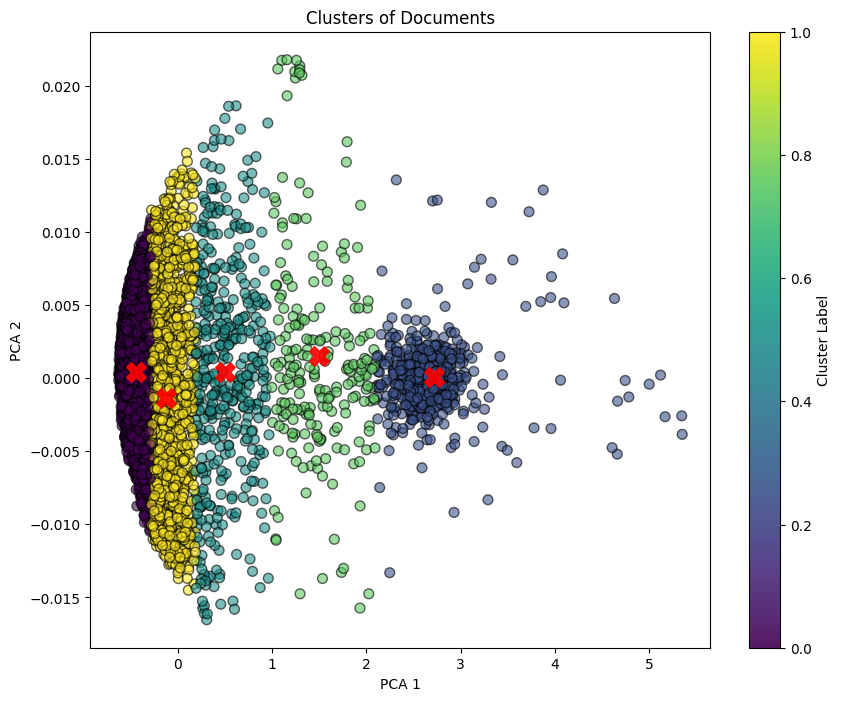

In [30]:
import matplotlib.pyplot as plt

# Assuming `X_pca` is your PCA-reduced data and `kmeans.labels_` are your cluster labels

# Scatter plot of the first two PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)

# Plot centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9, marker='X')

plt.title('Clusters of Documents')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster Label')

plt.show()


## Wrapper class for Lbl2Vec for use with SKLearn Hyperparameter Tuning

In [31]:
# def wrap_Lbl2Vec(model):
class Lbl2VecWrapper:
    def __init__(self, keywords, train_docs):
        self.lbl2vec = Lbl2Vec(keywords, train_docs)

    def fit(self, data):
        return self.lbl2vec.predict_new_docs(data)
    
    def get_params(self, deep=None):
        return self.lbl2vec.get_params(deep)
        
    # return Lbl2VecWrapper

## Score function:

In [32]:
def evaluate_lbl2_vec_silhouette(model, x):

    sim_scores = model.predict_new_docs(x)

    features = [f'label_{i}' for i in range(11)] 
    X = sim_scores[features]

    # Apply PCA to reduce dimensions
    pca = PCA(n_components=2)  # Adjust `n_components` as needed
    X_pca = pca.fit_transform(X)

    kmeans = KMeans(n_clusters=11, random_state=42)
    kmeans.fit(X_pca)

    silhouette_avg = silhouette_score(X_pca, kmeans.labels_)

    return silhouette_avg


## Hyperparameter Tuning:
Hyperparameters to tune:
1. similarity threshold [0, 1]
2. window n > 0
3. epochs n > 0
4. negative n > 0
5. clean outliers boolean

In [33]:
import itertools

In [34]:
# Create param_grid

train_docs = all_descriptions['tagged_desc'][all_descriptions.data_type == 'train']
validate_docs = all_descriptions['tagged_desc'][all_descriptions.data_type == 'validate']

keywords_list = [list(category_keywords['keywords'])]
tagged_documents = [train_docs]
min_count = [1]
window = range(10, 20)
negative = range(3, 7)
similarity_threshold = np.arange(start=0.3, stop=0.8, step=0.05, dtype=np.float32)
# clean_outliers = [True, False]

param_grid = [
    {
        'keywords_list': item[0],
        'tagged_documents': item[1],
        'min_count': item[2],
        'window': item[3],
        # 'negative': item[4],
        'similarity_threshold': item[4],
        # 'clean_outliers': item[5]
    }
    for item in itertools.product(*[
        keywords_list,
        tagged_documents,
        min_count,
        window,
        # negative,
        similarity_threshold,
        # clean_outliers
    ])
]

len(param_grid)

100

In [41]:
import tqdm

In [44]:
def find_best_hyperparameters(param_grid):

    params_scores = {}
    best_score = 0
    best_model = None
    best_params = None

    for param_set in param_grid:
        keywords = param_set['keywords_list']
        tagged_docs = param_set['tagged_documents']
        min_count = param_set['min_count']
        window = param_set['window']
        similarity_threshold = param_set['similarity_threshold']

        try:
            current_model = Lbl2Vec(
                keywords_list=keywords,
                tagged_documents=tagged_docs,
                min_count=min_count,
                window=window,
                similarity_threshold=similarity_threshold
            )
        except Exception as error:
            print(f'Params resulted in error: {error}\n{param_set=}')
            continue
        current_model.fit()
        current_model.predict_model_docs()
        
        sil_score = evaluate_lbl2_vec_silhouette(current_model, validate_docs)
        params_scores[param_set.values()] = sil_score
        print(f'{param_set=} yeilded score {sil_score}')

        if sil_score > best_score:
            best_score = sil_score
            best_model = current_model
            best_params = param_set
        elif sil_score == best_score: print('found param set which matches best')


    return best_score, best_model, best_params

In [43]:
best_score, best_model, best_params = find_best_hyperparameters(param_grid)

TypeError: 'module' object is not callable